In [49]:
import numpy as np
import matplotlib.pyplot as plt

In [50]:
def calculate_subsidence(subsidence_array, factor, initial_temp_sum, current_temp_sum):
    subsidence_value = factor * -(current_temp_sum - initial_temp_sum)
    subsidence_array = np.append(subsidence_array, subsidence_value)
    return subsidence_array

def mckenzie_model(temperature, diffusion_factor, subsidence_array, subsidence_factor, initial_temp_sum, index=None):
    if index is None:
        # 1D case
        temperature[1:-1] += diffusion_factor * (temperature[2:] - 2 * temperature[1:-1] + temperature[:-2])
        current_temp_sum = np.sum(temperature)
        subsidence_array = calculate_subsidence(subsidence_array, subsidence_factor, initial_temp_sum, current_temp_sum)
    else:
        # 2D case
        temperature[1:-1, 1:-1] += diffusion_factor * (
            temperature[:-2, 1:-1] + temperature[2:, 1:-1] + 
            temperature[1:-1, :-2] + temperature[1:-1, 2:] - 
            4 * temperature[1:-1, 1:-1]
        )
        # Boundary conditions
        temperature[:, 0] = temperature[:, 1]
        temperature[:, -1] = temperature[:, -2]
        current_temp_sum = np.sum(temperature, axis=0)[index]
        subsidence_array = calculate_subsidence(subsidence_array, subsidence_factor, initial_temp_sum, current_temp_sum)
    return temperature, subsidence_array

def generate_temperature_field(initial_temp, thermal_expansion, depth, thermal_diffusivity):
    temperature_field = depth * initial_temp * thermal_expansion / thermal_diffusivity
    temperature_field[temperature_field > initial_temp] = initial_temp
    return temperature_field

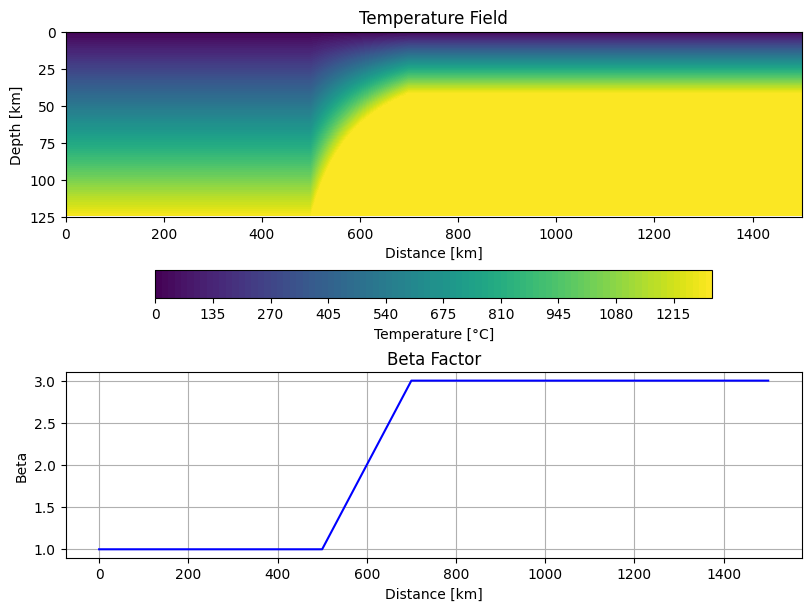

In [51]:
# Define constants and parameters
dx = 2000.0  # Vertical/horizontal spacing in meters
dt = 10000.0  # Time interval in years
seconds_per_year = 60 * 60 * 24 * 365.25  # Seconds in one year

# Physical properties
thermal_expansion = 3.28e-5  # Thermal expansion coefficient
thermal_diffusivity = 1e-6  # Thermal diffusivity
mantle_density = 3300.0  # Mantle density in kg/m^3
crust_density = 2700.0  # Crust density in kg/m^3
water_density = 1000.0  # Water density in kg/m^3

# Temperature and lithospheric parameters
base_temperature = 1300.0  # Temperature at the lithospheric base
crust_thickness = 35000.0  # Thickness of the crust in meters
lithosphere_thickness = 125000.0  # Thickness of the lithosphere in meters

# Generate spatial grid
x = np.arange(0, 1.5e6 + dx, dx)
z = np.arange(0, lithosphere_thickness, dx)
xx, zz = np.meshgrid(x, z)

# Auxiliary factors
fac = thermal_diffusivity * dt * seconds_per_year / (dx ** 2)
fac2 = dx * thermal_expansion * mantle_density / (mantle_density - water_density)

# Define stretching factor beta along the horizontal profile
beta_max = 3.0
beta = np.ones_like(x)
beta[x >= 0.7e6] = beta_max
transition_zone = (x >= 0.5e6) & (x <= 0.7e6)
beta[transition_zone] = (
    (x[transition_zone] - 0.5e6) * (beta_max - beta[0]) / 0.2e6 + beta[0]
)

# Generate initial temperature field using TempField function
temperature_field = generate_temperature_field(base_temperature, beta, zz, lithosphere_thickness)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(8, 6), constrained_layout=True)


# Plot 1: Temperature Field
contour = axs[0].contourf(xx / 1e3, zz / 1e3, temperature_field, 100)
axs[0].set_title('Temperature Field')
axs[0].set_xlabel('Distance [km]')
axs[0].set_ylabel('Depth [km]')
axs[0].set_ylim(lithosphere_thickness / 1e3, 0)
axs[0].set_xlim(0, 1500)
fig.colorbar(contour, ax=axs[0], orientation="horizontal", label="Temperature [°C]")

# Plot 2: Beta Factor
axs[1].plot(x / 1e3, beta, color='blue')
axs[1].set_title('Beta Factor')
axs[1].set_xlabel('Distance [km]')
axs[1].set_ylabel('Beta')
axs[1].grid()


plt.show()

In [52]:
# Constants and parameters
BASE_TEMPERATURE = 1300.0  # Temperature at the lithospheric base [°C]
DX = 2000.0  # Vertical/horizontal spacing in meters
DT = 10000.0  # Time interval in years
A = 125e3  # Lithosphere thickness [m]
SECONDS_PER_YEAR = 60 * 60 * 24 * 365.25

# Physical properties
THERMAL_EXPANSION = 3.28e-5  # Thermal expansion coefficient
THERMAL_DIFFUSIVITY = 1e-6  # Thermal diffusivity [m²/s]
MANTLE_DENSITY = 3300.0  # Mantle density in kg/m³
CRUST_DENSITY = 2700.0  # Crust density in kg/m³
WATER_DENSITY = 1000.0  # Water density in kg/m³
CRUST_THICKNESS = 35000.0  # Crust thickness in meters

# Auxiliary factors
FAC = THERMAL_DIFFUSIVITY * DT * SECONDS_PER_YEAR / (DX ** 2)
FAC2 = DX * THERMAL_EXPANSION * MANTLE_DENSITY / (MANTLE_DENSITY - WATER_DENSITY)


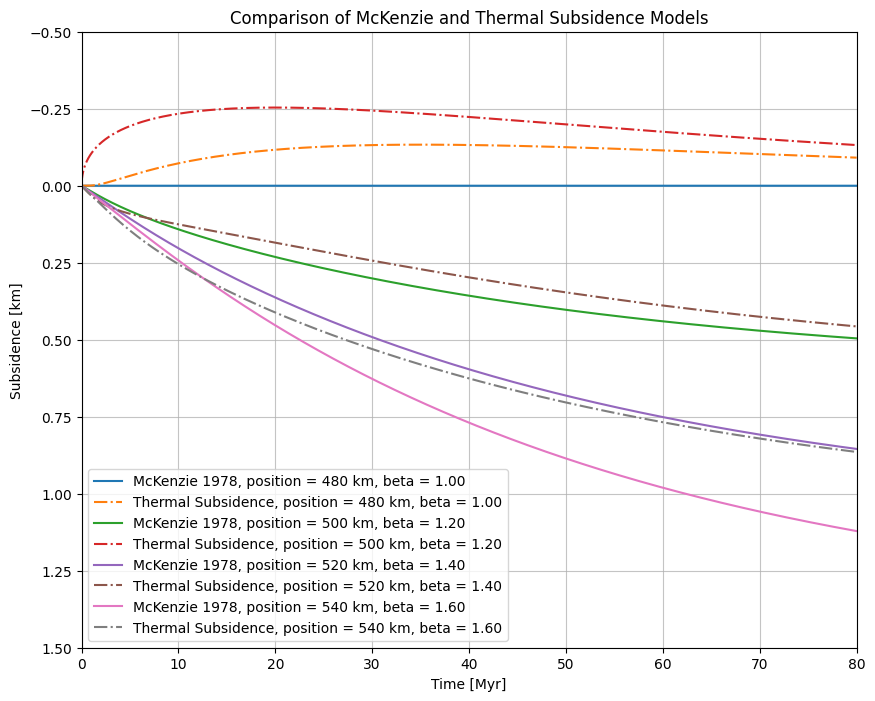

In [53]:
# Visualization settings
plt.figure(figsize=(10, 8))
plt.title('Comparison of McKenzie and Thermal Subsidence Models')
plt.xlabel('Time [Myr]')
plt.ylabel('Subsidence [km]')
plt.grid(alpha=0.75)

# Values for beta and position
beta_values = [1.0 + 1 * i / 5 for i in range(6)]
position_values = [0.48e6 + 0.1e6 * i / 5 for i in range(6)]

for i in range(4):
    pos = position_values[i]

    # Calculate initial subsidence for the current beta
    Si = A * ((MANTLE_DENSITY - CRUST_DENSITY) * CRUST_THICKNESS / A *
              (1 - (THERMAL_EXPANSION * BASE_TEMPERATURE * CRUST_THICKNESS / (2 * A))) - 
              (MANTLE_DENSITY * THERMAL_EXPANSION * BASE_TEMPERATURE / 2)) * (1 - 1 / beta_values[i]) / (
                MANTLE_DENSITY * (1 - THERMAL_EXPANSION * BASE_TEMPERATURE) - WATER_DENSITY)
    # Initialize temperature fields and sum parameters for models
    T_1d = generate_temperature_field(BASE_TEMPERATURE, beta_values[i], z, A)
    T0_1dsum = np.sum(T_1d)
    W_1d = np.array([])

    T_2d = generate_temperature_field(BASE_TEMPERATURE, beta, zz, A)
    index = np.where(x == pos)
    T0_2dsum = np.sum(T_2d, axis=0)[index]
    W_2d = np.array([])

    # Simulation over time
    t = 0
    tp = np.array([])
    while t < 81e6:
        T_1d, W_1d = mckenzie_model(T_1d, fac, W_1d, fac2, T0_1dsum)
        T_2d, W_2d = mckenzie_model(T_2d, fac, W_2d, fac2, T0_2dsum, index)
        tp = np.append(tp, t)
        t += dt

    # Plot the curves on the same graph for each beta and position
    plt.plot(tp / 1e6, W_1d / 1e3, label=f'McKenzie 1978, position = {pos / 1e3:.0f} km, beta = {beta_values[i]:.2f}')
    plt.plot(tp / 1e6, W_2d / 1e3, linestyle='-.', label=f'Thermal Subsidence, position = {pos / 1e3:.0f} km, beta = {beta_values[i]:.2f}')

plt.xlim(0, 80)
plt.ylim(1.5, -0.5)
plt.legend(loc='lower left', fontsize='medium')
plt.show()